### Подготовьте гистограммы по самым популярным жанрам, режиссерам, нац. принадлежностям фильмов, годам

In [29]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.classify import DecisionTreeClassifier, NaiveBayesClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


В анализируемом датасете 34886 строк. Всего 8 столбцов, все поля с типом данных object, за исключением поля Release Year. Пропущенные значения есть только в столбце Cast

In [4]:
for i in list(df.columns):
    print("Уникальных значений в столбце {0} : {1}".format(i, len(df[i].unique())))

Уникальных значений в столбце Release Year : 117
Уникальных значений в столбце Title : 32432
Уникальных значений в столбце Origin/Ethnicity : 24
Уникальных значений в столбце Director : 12593
Уникальных значений в столбце Cast : 32183
Уникальных значений в столбце Genre : 2265
Уникальных значений в столбце Wiki Page : 34070
Уникальных значений в столбце Plot : 33869


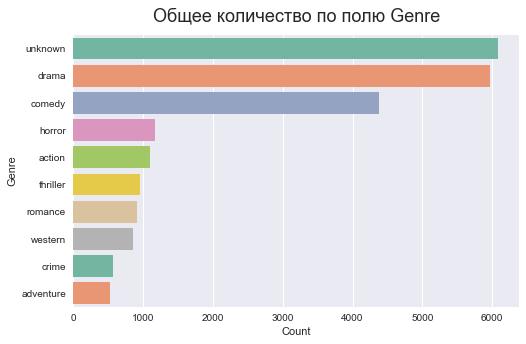

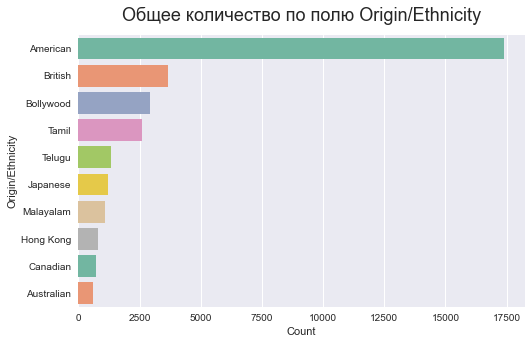

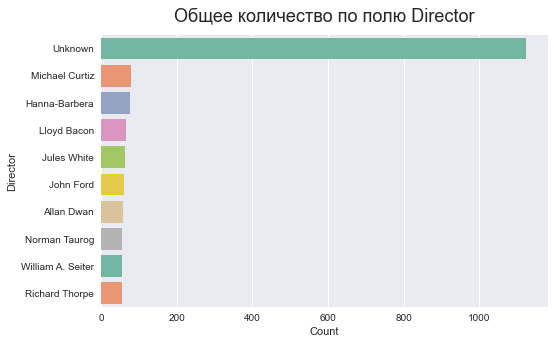

In [5]:
for i_col in ["Genre", "Origin/Ethnicity", "Director"] :
    d = df.copy()
    d['plus'] = d[i_col]
    data = d.groupby(i_col)['plus'].count().sort_values(ascending=False).reset_index().head(10)
    fig, ax = plt.subplots(figsize=(8,5))
    ax = sns.barplot(data=data, x=data['plus'], y=data[i_col], palette="Set2", ax=ax)
#     sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
    ax.set(xlabel='Count', ylabel=i_col)
#     seaborn.set_theme(style='white')
    ax.set_title(' '.join(['Общее количество по полю', i_col]), fontsize=18, pad=14)
    plt.show()
    

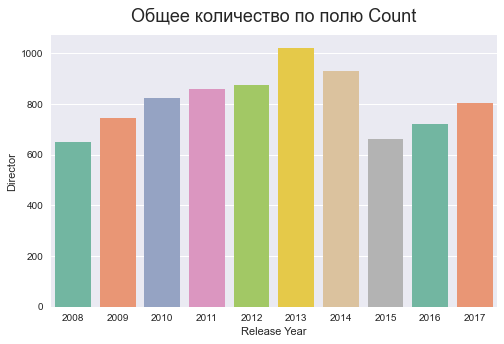

In [6]:
d = df.copy()
d['Count'] = d["Release Year"]
data = d.groupby("Release Year")['Count'].count().sort_index(ascending=False).reset_index().head(10)
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=data, x=data['Release Year'], y=data['Count'], palette="Set2", ax=ax)
ax.set(xlabel='Release Year', ylabel=i_col)
ax.set_title(' '.join(['Общее количество по полю', 'Count']), fontsize=18, pad=14)
plt.show()

Из всего датасета самый популярный жанр драма-почти 6000 фильмов

Так как цель проекта определить жанр, то отберем строки, где точно известен жанр

In [7]:
df = df[df['Genre']!='unknown']

На мой взгляд при определении жанра важен режисер, удалим значения с Unknown

In [8]:
df = df[df['Director']!='Unknown']

Поле с ссылкой на источник не влияет на определение жанра, удалим его

In [9]:
df = df.drop('Wiki Page', axis=1)

In [10]:
list(df["Genre"].unique())

['western',
 'comedy',
 'short',
 'short action/crime western',
 'short film',
 'biographical',
 'drama',
 'adventure',
 'horror',
 'crime',
 'drama, horror',
 'historical drama',
 'fantasy drama',
 'biographical drama',
 'documentary drama',
 'fantasy',
 'adventure serial',
 'epic',
 'historical',
 'comedy short',
 'comedy, western',
 'biography',
 'action adventure',
 'western drama',
 'short comedy',
 'comedy–drama',
 'romantic drama',
 'mystery',
 'crime drama',
 'romance',
 'sexual hygiene/exploitation film',
 'comedy drama',
 'war drama',
 'spy',
 'romantic comedy',
 'propaganda',
 'ww1 propaganda',
 'biopic',
 'animated series',
 'drama romance',
 'melodrama',
 'period drama',
 'swashbuckler',
 'romance drama',
 'drama, adventure',
 'crime comedy',
 'documentary',
 'comedy western',
 'fantasy, family',
 'war',
 'comedy, adventure',
 'fantasy, adventure',
 'thriller',
 'dramatic comedy',
 'romantic comedy/drama',
 'mystery, thriller',
 'crime thriller',
 'american football',
 'fa

In [11]:
# Заменим сокращенные жанры: 1) "sci-fi" на "science fiction" и 2) "romantic comedy" на "romance"
df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28365 entries, 6 to 34885
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      28365 non-null  int64 
 1   Title             28365 non-null  object
 2   Origin/Ethnicity  28365 non-null  object
 3   Director          28365 non-null  object
 4   Cast              27832 non-null  object
 5   Genre             28365 non-null  object
 6   Plot              28365 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


Стало 28365 строк, более чем на 6000 строк меньше. Посмотрим как визуально изменились данные

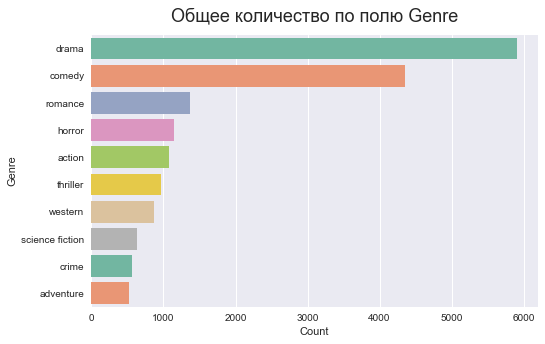

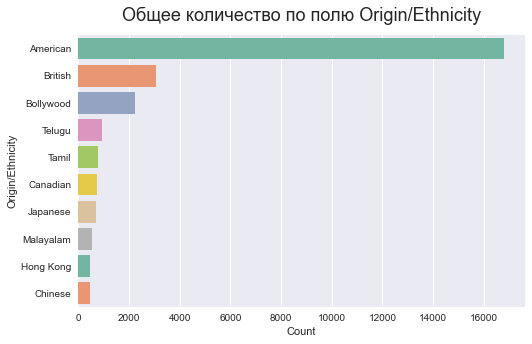

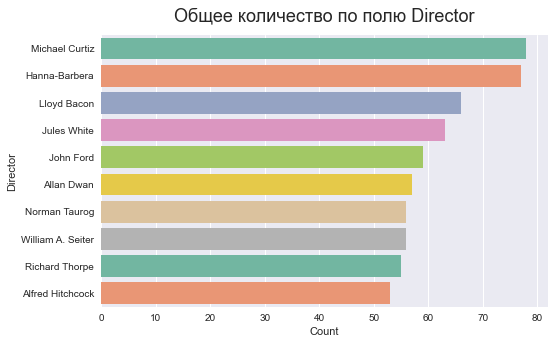

In [13]:
for i_col in ["Genre", "Origin/Ethnicity", "Director"] :
    d = df.copy()
    d['plus'] = d[i_col]
    data = d.groupby(i_col)['plus'].count().sort_values(ascending=False).reset_index().head(10)
    fig, ax = plt.subplots(figsize=(8,5))
    ax = sns.barplot(data=data, x=data['plus'], y=data[i_col], palette="Set2", ax=ax)
#     sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
    ax.set(xlabel='Count', ylabel=i_col)
#     seaborn.set_theme(style='white')
    ax.set_title(' '.join(['Общее количество по полю', i_col]), fontsize=18, pad=14)
    plt.show()

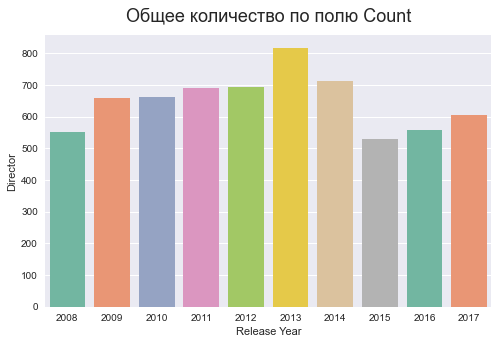

In [14]:
d = df.copy()
d['Count'] = d["Release Year"]
data = d.groupby("Release Year")['Count'].count().sort_index(ascending=False).reset_index().head(10)
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=data, x=data['Release Year'], y=data['Count'], palette="Set2", ax=ax)
ax.set(xlabel='Release Year', ylabel=i_col)
ax.set_title(' '.join(['Общее количество по полю', 'Count']), fontsize=18, pad=14)
plt.show()

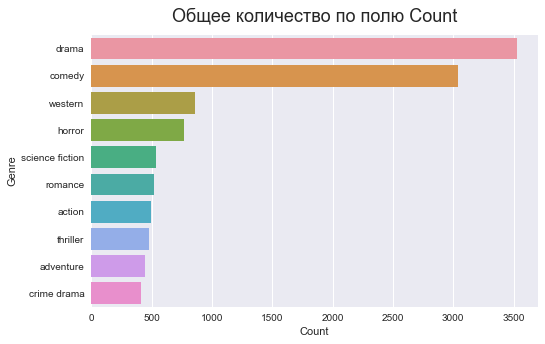

In [15]:
# Самые попоулярные жанры в Америке
d = df.copy()
d['Count'] = d['Origin/Ethnicity']
data = d[d['Origin/Ethnicity']=='American'].groupby("Genre")['Count'].count().sort_values(ascending=False).reset_index().head(10)
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.barplot(data=data, x=data['Count'], y=data["Genre"], ax=ax)
ax.set(xlabel='Count', ylabel='Genre')
ax.set_title(' '.join(['Общее количество по полю', 'Count']), fontsize=18, pad=14)
plt.show()

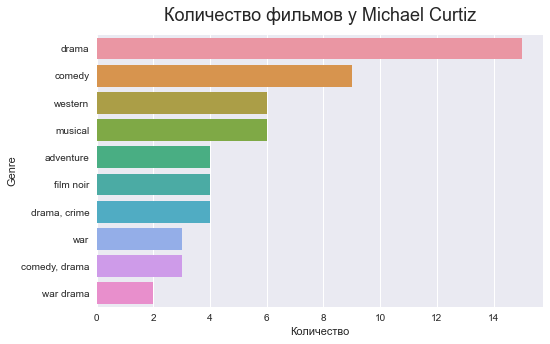

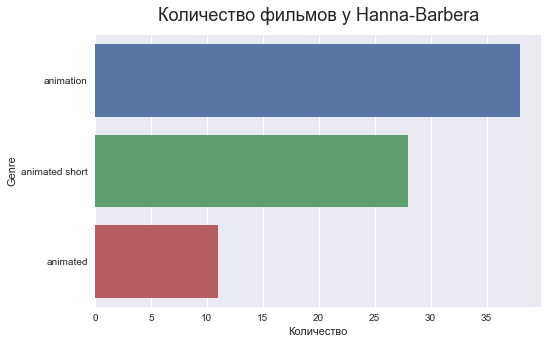

In [16]:
# Самые попоулярные жанры в Michael Curtis и Hanna-Barbera
d = df.copy()
# d['Count'] = d['Origin/Ethnicity']
for director in ['Michael Curtiz','Hanna-Barbera']:
    data = d[d['Director']==director].groupby("Genre")['Director'].count().sort_values(ascending=False).reset_index().head(10)
    fig, ax = plt.subplots(figsize=(8,5))
    ax = sns.barplot(data=data, x=data['Director'], y=data["Genre"], ax=ax)
    ax.set(xlabel='Количество', ylabel='Genre')
    ax.set_title(' '.join(['Количество фильмов у', director]), fontsize=18, pad=14)
    plt.show()

загружаем отзывы

In [165]:
reviews = pd.read_csv("archive.zip")
reviews = reviews[['year', 'movie', 'country', 'overview', 'director', 'screenwriter', 'actors']]
reviews['movie'] = reviews['movie'].apply(lambda x: x.lower())
reviews.head()

,year,movie,country,overview,director,screenwriter,actors
0,1994,побег из шоушенка,США,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...
1,1999,зеленая миля,США,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...
2,1994,форрест гамп,США,От лица главного героя Форреста Гампа; слабоум...,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...
3,1993,список шиндлера,США,Фильм рассказывает реальную историю загадочног...,Стивен Спилберг,Стивен Зеллиан; Томас Кенилли,Лиам Нисон; Бен Кингсли; Рэйф Файнс; Кэролайн ...
4,2011,1+1,Франция,Пострадав в результате несчастного случая; бог...,Оливье Накаш; Эрик Толедано,Оливье Накаш; Филипп Поццо ди Борго; Эрик Т...,Франсуа Клюзе; Омар Си; Анн Ле Ни; Одри Флеро;...


In [189]:
# Удаляем пробклы в конце названий
reviews['movie'] = reviews['movie'].str.strip()

In [19]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          250 non-null    int64 
 1   movie         250 non-null    object
 2   country       250 non-null    object
 3   overview      250 non-null    object
 4   director      250 non-null    object
 5   screenwriter  250 non-null    object
 6   actors        250 non-null    object
dtypes: int64(1), object(6)
memory usage: 13.8+ KB


In [164]:
rev_gen = pd.read_csv("kp_all_movies.csv")
rev_gen.rename(columns={'name_rus': 'movie'}, inplace=True)
rev_gen = rev_gen[['movie_id', 'movie', 'genres']]
rev_gen['movie'] = rev_gen['movie'].apply(lambda x: x.lower())
rev_gen['genres'] = rev_gen['genres'].apply(lambda x: str(x).strip('[]').lower())
rev_gen.head()

,movie_id,movie,genres
0,10000,иезавель,"драма, мелодрама"
1,100049,47 ронинов,"боевик, драма, история"
2,10005,живем один раз,"фильм-нуар, драма, криминал"
3,100053,колдун 2,"фэнтези, боевик"
4,100096,"ильза, тигрица из сибири",ужасы


In [205]:
rev_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36417 entries, 0 to 36416
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  36417 non-null  int64 
 1   movie     36417 non-null  object
 2   genres    36417 non-null  object
dtypes: int64(1), object(2)
memory usage: 853.6+ KB


In [206]:
rev = reviews.merge(rev_gen, on='movie', how='left')

In [207]:
rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          330 non-null    int64  
 1   movie         330 non-null    object 
 2   country       330 non-null    object 
 3   overview      330 non-null    object 
 4   director      330 non-null    object 
 5   screenwriter  330 non-null    object 
 6   actors        330 non-null    object 
 7   movie_id      303 non-null    float64
 8   genres        303 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 25.8+ KB


In [208]:
rev.groupby('movie')['movie'].count().sort_values(ascending=True)

movie
...а зори здесь тихие                       1
октябрьское небо                            1
они сражались за родину                     1
операция «ы» и другие приключения шурика    1
остров проклятых                            1
                                           ..
малыш                                       4
красавица и чудовище                        5
ромео и джульетта                           5
игра                                        6
одержимость                                 8
Name: movie, Length: 250, dtype: int64

In [209]:
rev[rev['movie']=='одержимость']

,year,movie,country,overview,director,screenwriter,actors,movie_id,genres
88,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,102288.0,"триллер, драма, детектив"
89,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,23737.0,"триллер, драма, мелодрама, детектив"
90,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,406348.0,"триллер, драма"
91,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,5240.0,ужасы
92,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,56969.0,"драма, мелодрама, криминал"
93,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,725190.0,"драма, музыка"
94,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,789.0,"драма, детектив"
95,2013,одержимость,США,Эндрю мечтает стать великим. Казалось бы; вот-...,Дэмьен Шазелл,Дэмьен Шазелл,Майлз Теллер; Дж.К. Симмонс; Пол Райзер; Мелис...,807816.0,драма


In [168]:
pattern = r'^[0-9]+' #регулярное выражение для обрезания id
movie_id = list()
review_movie = list()
status = list()
path = '/Users/olgakamskaa/Desktop/dataset'
for fol in ['neu','neg', 'pos']:
    path = '/'.join(['/Users/olgakamskaa/Desktop/dataset', fol])
    for dir,folder,files in os.walk(path):
        for i_file in files:
            if i_file != '.DS_Store':
                movie_id.append(re.findall(pattern, i_file)[0])
                status.append(fol)
                with open('/'.join([path, i_file]), 'r') as f:
                    review_movie.append(str(f.readlines()).strip('[]'))

In [126]:
len(movie_id)

131669

In [143]:
len(review_movie)

131669

In [150]:
len(status)

131669

In [176]:
# Создаем датафрейм
kino_rev = pd.DataFrame({'movie_id':movie_id, 'review':review_movie, 'status':status})
kino_rev = kino_rev.astype({"movie_id": float})

In [170]:
kino_rev.head()

,movie_id,review,status
0,40676,'Нашумевший кинохит Анаконда не мог остаться в...,neu
1,197864,"'Фильм об истории человека, который имеет все,...",neu
2,9458,"""Мне все говорили 'фильм фигня', 'фильм не опр...",neu
3,63882,"""Итак, перед нами творение итальянского режисс...",neu
4,466990,"'Одиннадцатый сезон\n', '\n', 'Что происходит ...",neu


In [196]:
rev = rev.merge(kino_rev, on='movie_id', how='left')

In [197]:
rev.head()

,year,movie,country,overview,director,screenwriter,actors,movie_id,genres,review,status
0,1994,побег из шоушенка,США,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,326.0,"драма, криминал",NaN,NaN
1,1999,зеленая миля,США,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,435.0,"фэнтези, драма, криминал, детектив","'Американцы очень любят снимать кино, где мест...",neu
2,1999,зеленая миля,США,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,435.0,"фэнтези, драма, криминал, детектив",'Зеленая миля - это такая грустная сказка о до...,neu
3,1999,зеленая миля,США,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,435.0,"фэнтези, драма, криминал, детектив","'О чем этот фильм, думаю, все без меня и так з...",neu
4,1999,зеленая миля,США,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,435.0,"фэнтези, драма, криминал, детектив",'1935ый год. Америка никак не может оправиться...,neu


In [203]:
rev[~rev['status'].isin(['neu','neg', 'pos'])].groupby('movie_id')['movie_id'].count()

movie_id
301.0       1
304.0       1
312.0       1
322.0       1
326.0       1
           ..
772017.0    1
775276.0    1
806934.0    1
808639.0    1
843175.0    1
Name: movie_id, Length: 232, dtype: int64

In [204]:
rev[~rev['status'].isin(['neu','neg', 'pos'])]

,year,movie,country,overview,director,screenwriter,actors,movie_id,genres,review,status
0,1994,побег из шоушенка,США,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,326.0,"драма, криминал",NaN,NaN
201,1993,список шиндлера,США,Фильм рассказывает реальную историю загадочног...,Стивен Спилберг,Стивен Зеллиан; Томас Кенилли,Лиам Нисон; Бен Кингсли; Рэйф Файнс; Кэролайн ...,329.0,"драма, биография, история",NaN,NaN
202,2011,1+1,Франция,Пострадав в результате несчастного случая; бог...,Оливье Накаш; Эрик Толедано,Оливье Накаш; Филипп Поццо ди Борго; Эрик Т...,Франсуа Клюзе; Омар Си; Анн Ле Ни; Одри Флеро;...,535341.0,"драма, комедия, биография",NaN,NaN
203,2010,начало,США,Кобб — талантливый вор; лучший из лучших в опа...,Кристофер Нолан,Кристофер Нолан,Леонардо ДиКаприо; Джозеф Гордон-Левитт; Эллен...,447301.0,"фантастика, боевик, триллер, драма, детектив",NaN,NaN
226,1994,леон,Франция,Профессиональный убийца Леон; не знающий пощад...,Люк Бессон,Люк Бессон,Жан Рено; Гари Олдман; Натали Портман; Дэнни А...,389.0,"триллер, драма, криминал",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4887,2013,мандарины,Эстония,1992 год; Абхазия. Древнее эстонское село; рас...,Заза Урушадзе,Заза Урушадзе,Лембит Ульфсак; Георгий Накашидзе; Элмо Нюгане...,772017.0,"драма, военный",NaN,NaN
4888,1979,крамер против крамера,США,Тед Крамер; целиком посвятив себя карьере; не ...,Роберт Бентон,Роберт Бентон; Эйвери Кормэн,Дастин Хоффман; Мэрил Стрип; Джейн Александр; ...,1902.0,драма,NaN,NaN
4989,1985,иди и смотри,СССР,Флера — шестнадцатилетний мальчишка; откопавши...,Элем Климов,Алесь Адамович; Элем Климов,Алексей Кравченко; Ольга Миронова; Любомирас Л...,42571.0,"драма, военный",NaN,NaN
4990,1981,профессионал,Франция,Убить президента африканской республики. Такое...,Жорж Лотнер,Мишель Одиар; Патрик Александер; Жорж Лотне...,Жан-Поль Бельмондо; Жан Дезайи; Сирил Клер; Ма...,37612.0,"драма, комедия",NaN,NaN


In [ ]:
for i_col in ["Genre", "Origin/Ethnicity", "Director"] :
    d = df.copy()
    d['plus'] = d[i_col]
    data = d.groupby(i_col)['plus'].count().sort_values(ascending=False).reset_index().head(10)
    fig, ax = plt.subplots(figsize=(8,5))
    ax = sns.barplot(data=data, x=data['plus'], y=data[i_col], palette="Set2", ax=ax)
#     sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
    ax.set(xlabel='Count', ylabel=i_col)
#     seaborn.set_theme(style='white')
    ax.set_title(' '.join(['Общее количество по полю', i_col]), fontsize=18, pad=14)
    plt.show()

### 2.Подготовьте sentiment analysis по отзывам (используя  nltk.classify) и оцените, как распределяется sentiment по актерам, режиссерам и жанрам

In [ ]:
import pickle
import os
import string
import warnings

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

In [ ]:
warnings.filterwarnings('ignore')

загружаем отзывы

In [ ]:

# movies_df = movies_df[(movies_df["Origin/Ethnicity"]=="American") | (movies_df["Origin/Ethnicity"]=="British")]
# movies_df = movies_df[["Plot", "Genre"]]
# drop_indices = movies_df[movies_df["Genre"] == "unknown" ].index
# movies_df.drop(drop_indices, inplace=True)



# Выберем самые популярные жанры
shortlisted_genres = df_copy["Genre"].value_counts().reset_index(name="count").query("count > 100")["index"].tolist()
df_copy = df_copy[df_copy["Genre"].isin(shortlisted_genres)].reset_index(drop=True)

# Выберем случайным образом 1 жанр из тех, где указано несколько жанров
df_copy = df_copy.sample(frac=1, random_state=1).reset_index(drop=True)

# Sample roughly equal number of movie plots from different genres (to reduce class imbalance issues)
df_copy = df_copy.groupby("Genre").head(400).reset_index(drop=True)

label_encoder = LabelEncoder()
df_copy["genre_encoded"] = label_encoder.fit_transform(df_copy["Genre"].tolist())

# df_copy = df_copy[["Plot", "Genre", "genre_encoded"]]
df_copy

In [ ]:
tokenizer = WordPunctTokenizer()
reviews['review_token'] = reviews['review'].apply(lambda x: tokenizer.tokenize(x.lower()))
reviews.head(10)

In [ ]:
def vectorize(tokens):
    ''' This function takes list of words in a sentence as input 
    and returns a vector of size of filtered_vocab.It puts 0 if the 
    word is not present in tokens and count of token if present.'''
    vector=[]
    for w in filtered_vocab:
        vector.append(tokens.count(w))
    return vector
def unique(sequence):
    '''This functions returns a list in which the order remains 
    same and no item repeats.Using the set() function does not 
    preserve the original ordering,so i didnt use that instead'''
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

stops = set(stopwords.words('english'))

#list of special characters.You can use regular expressions too
special_char=[",",":"," ",";",".","?","-","!","/","<","&","'", "1"]

In [ ]:
# reviews['review_token'] = reviews['review_token'].apply(lambda x: i if i in special_char else 0 for i in reviews['review_token'] )

In [ ]:
for i_num, i_str in enumerate(reviews['review_token']):
    filtered_text = []
    for i_word in i_str:
        if (i_word.isalpha() and i_word not in stops):
            filtered_text.append(i_word)
    reviews['review_token'][i_num] = filtered_text
        


In [ ]:
reviews['code_sent'] = reviews['sentiment'].map({'negative':0, 'positive':1})
reviews

In [ ]:
from zipfile import ZipFile
zipfile = 'IMDB_Movies_2021.db.zip'
z = ZipFile(zipfile)
z.infolist()

In [ ]:
# pd.read_csv("IMDB_Movies_2021.db")

In [ ]:
import sqlite3

# Create your connection.
cnx = sqlite3.connect('IMDB_Movies_2021.db')

reviews = pd.read_sql_query("tables", cnx)
# reviews = pd.read_csv("IMDB_Movies_2021.db.zip")
reviews.head()

In [ ]:
# подгружаю отзывы, джойню по году/названию

In [ ]:
# поле отзывы токенизирую, стем, лемм

In [ ]:
# разделяю выборку на test train по очереди обучаю модели по актерам, режиссерам и жанрам
from sklearn.model_selection import train_test_split

# X = reviews.drop('code_sent', axis=1)
X = reviews['review_token']
y = reviews['code_sent']

X_train , X_test, y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import SVC
from sklearn import model_selection

In [ ]:
classifier = nltk.classify.SklearnClassifier(DecisionTreeClassifier())
classifier.train(X_train, y_train)
accuracy = nltk.classify.accuracy(classifier, X_test)

In [ ]:
from nltk import LogisticRegression
classifier = nltk.classify.SklearnClassifier(LogisticRegression(C=1000))
classifier.train(X_train, y_train)
accuracy = nltk.classify.accuracy(classifier, X_test)

In [ ]:
from nltk import BernoulliNB
classifier = nltk.classify.SklearnClassifier(BernoulliNB(binarize=False))
classifier.train(X_train, y_train)
accuracy = nltk.classify.accuracy(classifier, X_test)

In [ ]:
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(X_train, y_train)

In [ ]:
X_train

In [ ]:
# проверяю качество. Буду пробовать различные модели


In [ ]:
# визуализирую анализ

### Необходимо написать на базе BERT определитель жанра фильма: 
 - На вход подается сюжет фильма. На выходе - жанр  sample: https://www.kaggle.com/balraj98/movie-genre-prediction-from-wiki-plot-using-bert 



In [ ]:
# клонирование берт
# git clone https://github.com/google-research/bert.git

In [ ]:
# from simpletransformers.classification import ClassificationModel

# model_args = {
#     "reprocess_input_data": True,
#     "overwrite_output_dir": True,
#     "save_model_every_epoch": False,
#     "save_eval_checkpoints": False,
#     "max_seq_length": 512,
#     "train_batch_size": 16,
#     "num_train_epochs": 4,
# }

# # Create a ClassificationModel
# model = ClassificationModel('bert', 'bert-base-cased', num_labels=len(shortlisted_genres), args=model_args)

In [ ]:
#  Создание токенизатора BERT
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)


In [ ]:
#  Подготовка Данных Для Обучения
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]

BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)


In [ ]:
#  Создание модели

class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output


#     гипперпараметры
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)




In [ ]:
# компилирование

if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])


In [ ]:
#  обучаем
text_model.fit(train_data, epochs=NB_EPOCHS)

In [ ]:
#  проверяем результат на тестовом наборе 
results = text_model.evaluate(test_dataset)
print(results)